In [1]:

import sys
sys.path.append('/Users/charleshiggins/Personal/CharlesPhD/CodeRepo/xai_intervention/RL-LRP/')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from experiments import SimpleRNet, apply_threshold, CosineDistanceLoss, ManualCNN, HybridCosineDistanceCrossEntopyLoss
from matplotlib import pyplot as plt
import numpy as np
# comment out when running locally
from experiments import WrapperNet
# comment out when running locally            

/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def train_model(model, optimizer, criterion, train_loader, device, attention_function):
    total_loss = 0
    model.train()
    for _ in range(10):
        data, target = next(iter(train_loader))
        data, target = data.to(device), target.to(device)
        target_map = attention_function(data, threshold=0.95) # threshold is 0.99
        optimizer.zero_grad()
        output_classification, output = model(data)
        loss = criterion(output, target_map, output_classification, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    return total_loss

def test_model(model, criterion, test_loader, device, attention_function):
    model.eval()
    test_loss = 0
    correct = 0
    total_seen = 0
    with torch.no_grad():
        for _ in range(10):
            data, target = next(iter(test_loader))
            data, target = data.to(device), target.to(device)
            target_map = attention_function(data, threshold=0.95)
            output_classification, output = model(data)
            test_loss += criterion(output, target_map, output_classification, target).item()
            correct += output_classification.argmax(dim=1).eq(target).sum().item()
            total_seen += len(target)
    test_loss /= total_seen
    accuracy = (correct / total_seen) * 100
    return test_loss, accuracy    

def plot_heatmap_comparison(model, test_loader, device, attention_function, epoch):
    data, target = next(iter(test_loader))
    target_map = attention_function(data, threshold=0.95)
    output_classification, output = model(data.to(device), target.to(device))
    num = np.random.randint(0, len(target))
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(output[num][0].detach().numpy(), cmap='hot')
    axes[0].set_title(f'LRP Output after {epoch} iterations')
    axes[1].imshow(target_map[num][0], cmap='hot')
    axes[1].set_title('Target Heatmap (Ground Truth)')
    axes[2].imshow(data[num][0].detach().numpy(), cmap='gray')
    axes[2].set_title('Input Image (Original)')
    plt.show()

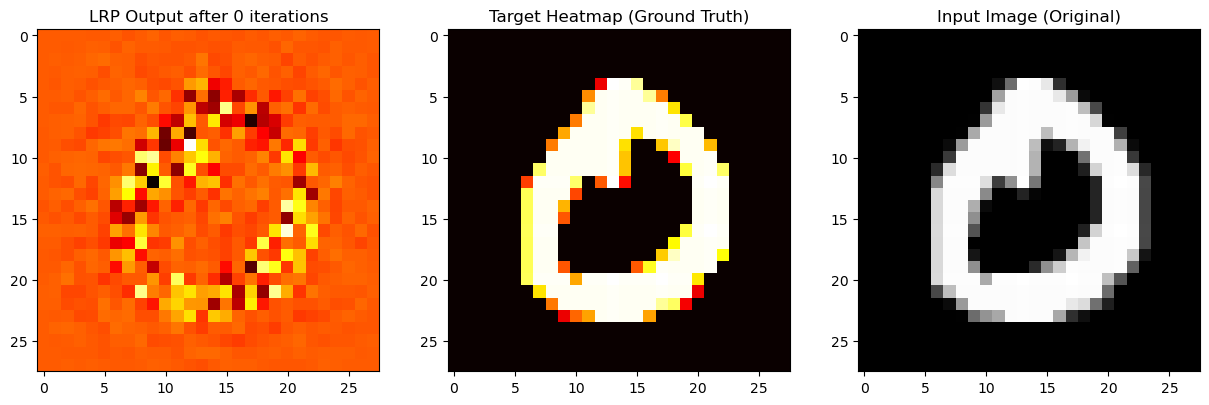

Epoch: 0, Test Classification Loss: 0.029420936666429042, Accuracy: 11.875
Epoch: 0, Training Loss: 0.00026437356074651084
Epoch: 1, Test Classification Loss: 0.02046735193580389, Accuracy: 46.09375
Epoch: 1, Training Loss: 0.00019868209064006806
Epoch: 2, Test Classification Loss: 0.014815911557525397, Accuracy: 60.46875000000001
Epoch: 2, Training Loss: 0.0001353864997625351
Epoch: 3, Test Classification Loss: 0.01107637882232666, Accuracy: 70.15625
Epoch: 3, Training Loss: 0.00010323145786921184
Epoch: 4, Test Classification Loss: 0.008179587917402387, Accuracy: 80.15625
Epoch: 4, Training Loss: 8.239007045825322e-05


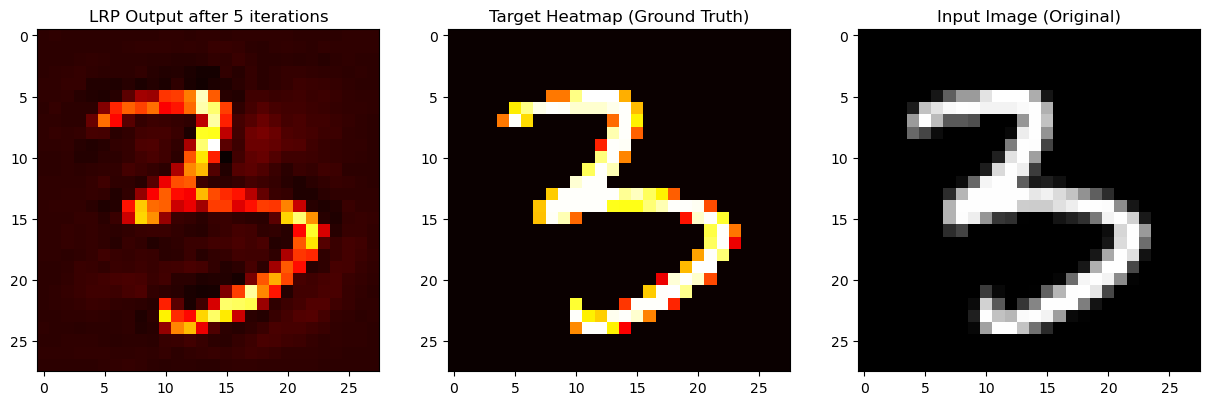

Epoch: 5, Test Classification Loss: 0.00611331076361239, Accuracy: 85.46875
Epoch: 5, Training Loss: 6.325507909059524e-05
Epoch: 6, Test Classification Loss: 0.006417743628844619, Accuracy: 85.3125
Epoch: 6, Training Loss: 5.305960973103841e-05
Epoch: 7, Test Classification Loss: 0.0049431183841079475, Accuracy: 88.90625
Epoch: 7, Training Loss: 5.7744829853375756e-05
Epoch: 8, Test Classification Loss: 0.004589150962419808, Accuracy: 90.9375
Epoch: 8, Training Loss: 4.6880447367827094e-05
Epoch: 9, Test Classification Loss: 0.004201444354839623, Accuracy: 91.71875
Epoch: 9, Training Loss: 4.737673153479894e-05


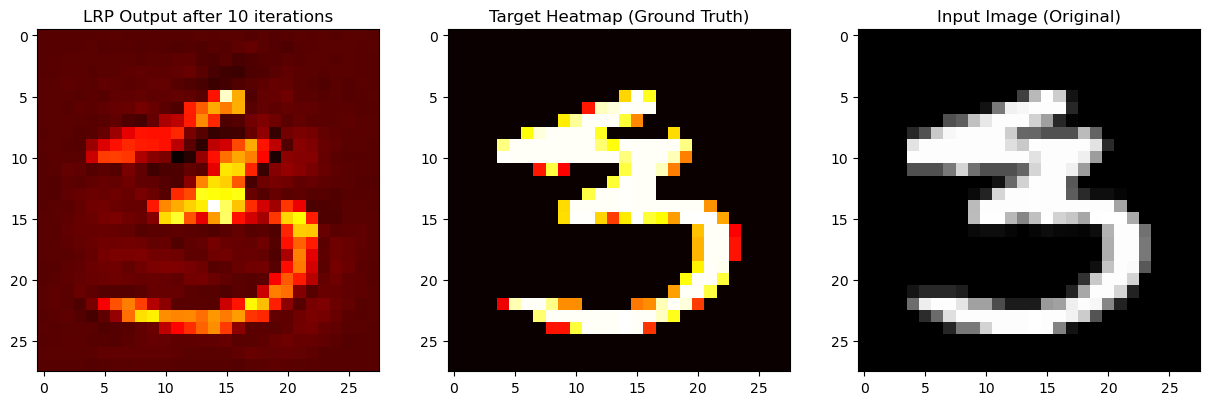

Epoch: 10, Test Classification Loss: 0.003493043687194586, Accuracy: 92.8125
Epoch: 10, Training Loss: 4.291766037543615e-05
Epoch: 11, Test Classification Loss: 0.0033510621637105943, Accuracy: 93.28125
Epoch: 11, Training Loss: 3.578371008237203e-05
Epoch: 12, Test Classification Loss: 0.0031629938166588545, Accuracy: 93.4375
Epoch: 12, Training Loss: 3.0491981903711954e-05
Epoch: 13, Test Classification Loss: 0.0032063940772786735, Accuracy: 94.21875
Epoch: 13, Training Loss: 3.5742177069187164e-05
Epoch: 14, Test Classification Loss: 0.003554079437162727, Accuracy: 92.65625
Epoch: 14, Training Loss: 3.4873098880052566e-05


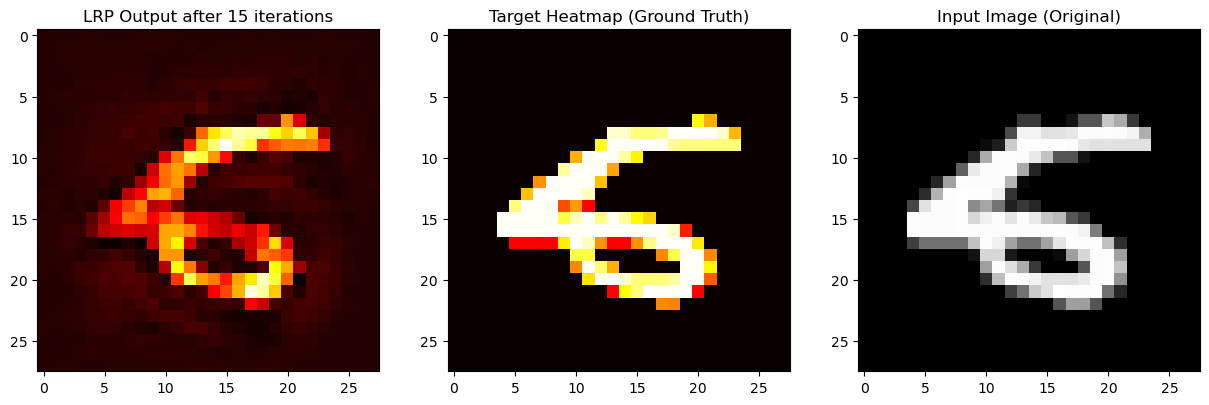

Epoch: 15, Test Classification Loss: 0.0035715555655770003, Accuracy: 93.125
Epoch: 15, Training Loss: 3.28904344389836e-05
Epoch: 16, Test Classification Loss: 0.002168612269451842, Accuracy: 95.625
Epoch: 16, Training Loss: 3.388383810718854e-05
Epoch: 17, Test Classification Loss: 0.0033213339513167737, Accuracy: 93.125
Epoch: 17, Training Loss: 3.19934190561374e-05
Epoch: 18, Test Classification Loss: 0.002713016327470541, Accuracy: 94.84375
Epoch: 18, Training Loss: 2.589880588153998e-05
Epoch: 19, Test Classification Loss: 0.0030641021206974984, Accuracy: 94.0625
Epoch: 19, Training Loss: 2.7200497935215633e-05


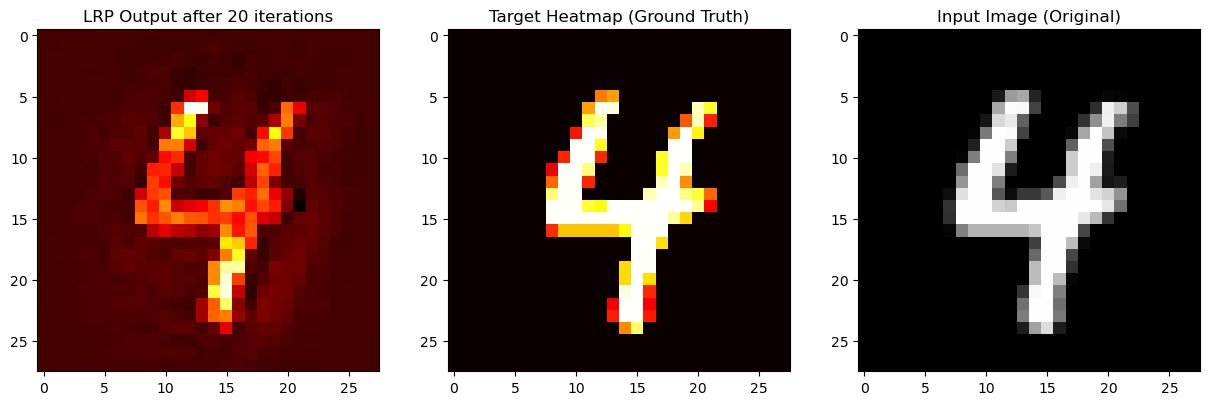

Epoch: 20, Test Classification Loss: 0.0034635819029062986, Accuracy: 94.21875
Epoch: 20, Training Loss: 2.771076758702596e-05
Epoch: 21, Test Classification Loss: 0.002865332586225122, Accuracy: 93.125
Epoch: 21, Training Loss: 2.5824530236423015e-05
Epoch: 22, Test Classification Loss: 0.0015801374684087932, Accuracy: 97.03125


KeyboardInterrupt: 

In [4]:

# define device for GPU compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and transform datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the network and optimizer for the underlying network

# now wrap the network in the LRP class
model = WrapperNet(SimpleRNet(), hybrid_loss=True)
# model = ManualCNN(hybrid_loss=True)
optimizer= optim.Adam(model.parameters(), lr=1e-3)

# define the loss functions for each
# lambda parameter weights cross entropy loss with CosineDistance. 
# The higher the lambda parameter, the more weight is given to the cosine distnace loss
criterion = HybridCosineDistanceCrossEntopyLoss(_lambda=0.3)
# Move to device
model.to(device)

EPOCHS = 100
VISUALIZE_FREQ = 5
for x in range(EPOCHS):
    if x % VISUALIZE_FREQ == 0:
        plot_heatmap_comparison(model, test_loader, device, apply_threshold, x)
    test_classification_loss, accuracy = test_model(model, criterion, test_loader, device, apply_threshold)
    print(f'Epoch: {x}, Test Classification Loss: {test_classification_loss}, Accuracy: {accuracy}')
    train_loss = train_model(model, optimizer, criterion, train_loader, device, apply_threshold)
    print(f'Epoch: {x}, Training Loss: {train_loss}')
    
